# Probability of killing proportional to $O_2$ concentration

## Imports

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.integrate import solve_bvp

from tumorsphere.core.simulation import Simulation

sns.set_theme(style="darkgrid")

## Simulation

In [2]:
sim = Simulation(
    prob_stem=[0.8],
    prob_diff=[0],
    # prob_supervivence_radiotherapy=[0.6],
    num_of_realizations=1,
    num_of_steps_per_realization=30,
)

In [3]:
# sim.simulate_parallel(
#     sql=False,
# )

## Reading the Simulation Data and Defining Parameters

In [4]:
# Let's load the data for ps=0.8 and tf=28
df = pd.read_csv(
    "radiotherapy_active_targeted_culture_tf=28_pd=0_ps=0.8_rng_seed=1099062448631258.csv"
)

# We drop the old index column
df.drop(columns=["Unnamed: 0"], inplace=True)

# Now, we rename position_norm to position_norm_in_radii
df.rename(columns={"position_norm": "position_norm_in_radii"}, inplace=True)

# ----- Parameters -----
cellular_radius_in_microns = 8  # microns (this is the value for MCF7)
spheroid_radius_in_cellular_radii = df.position_norm_in_radii.max()

print(
    f"Max position in cellular radii (spheroid radius): {spheroid_radius_in_cellular_radii}"
)

spheroid_radius_in_microns = (
    spheroid_radius_in_cellular_radii * cellular_radius_in_microns
)

# Parameter L = \sqrt{D / k}, where D is the diffusion coefficient and k is
# the consumption constant, experimentally determined to be 100 microns
l_in_microns = 100

# Let's add a new column with the position in microns
df["position_norm_in_microns"] = (
    df["position_norm_in_radii"] * cellular_radius_in_microns
)

df.head()

Max position in cellular radii (spheroid radius): 39.9294518498879


,position_norm_in_radii,stemness,active,susceptibility,position_norm_in_microns
0,0.000000,True,False,0.894803,0.000000
1,2.000000,True,False,0.633878,16.000000
2,2.000000,False,False,0.612602,16.000000
3,2.974926,False,False,0.078773,23.799412
4,4.683681,False,False,0.829732,37.469450


## Diffusion Equation Solution
### Solving the ODEs

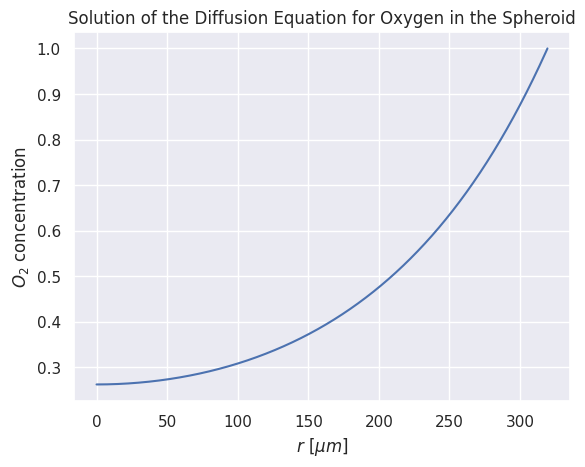

In [5]:
# ------ Define the system of ODEs ------


def odes(r, y, l_in_microns):
    """
    Defines the system of ODEs for the diffusion equation.

    Here, y = [y0, y1] = [f(r), df/dr], where f(r) is the concentration of the
    diffusing oxygen and df/dr is the derivative of f with respect to r. The
    original diffusion equation with spherical symmetry is given by:
    d^2f/fr^2 + (2/r)df/dr - f/L^2 = 0
    where L = sqrt(D / k), where D is the diffusion coefficient and k is the
    consumption constant. Then, the system of ODEs is:
    dy0/dr = y1
    dy1/dr = y0 / L^2 - (2 / r) * y1

    Parameters
    ----------
    r : float or ndarray
        Radial coordinate(s) at which to evaluate the ODEs.
    y : ndarray
        Array containing the dependent variables [f(r), df/dr].
    l_in_microns : float
        Parameter L = sqrt(D / k), where D is the diffusion coefficient
        and k is the consumption constant.

    Returns
    -------
    dydr : ndarray
        Array containing the derivatives [df/dr, d^2f/dr^2].
    """
    y0, y1 = y
    dy0_dr = y1
    dy1_dr = y0 / l_in_microns**2 - (2 / r) * y1
    return np.vstack((dy0_dr, dy1_dr))


# ------ Define the boundary conditions ------


def bc(ya, yb):
    """
    Defines the boundary conditions for the ODE system.

    The function bc returns an array containing the residuals for each
    boundary condition. A residual is the difference between the desired value
    and the actual value provided by the solution. *So residuals are what we
    want to be zero.* The boundary conditions for the diffusion equation are:
    1. df/dr (r=0) = 0, i.e., ya[0] = 0
    (no flux at the center of the spheroid);
    2. f(r=R) = 1, i.e., yb[1] = 1  =>  yb[1] - 1 = 0
    (oxygen concentration at the surface of the spheroid is 1).


    Parameters
    ----------
    ya : ndarray
        Array containing the values of y(r=a) = [y0(r=a), y1(r=a), ...].
        In this case, a = 0, so,
        ya = y(r=0) = [y0(r=0), y1(r=0)] = [f(0), df/dr(0)].
    yb : ndarray
        Array containing the values of y(r=b) = [y0(r=b), y1(r=b), ...].
        In this case, b = R, so,
        yb = y(r=R) = [y0(r=R), y1(r=R)] = [f(R), df/dr(R)].

    Returns
    -------
    bcs : ndarray
        Array containing the residuals of the boundary conditions
        [df/dr (r=0), f(r=R) - 1].
    """
    return np.array([ya[1], yb[0] - 1])


# Vector of radial coordinates
r = np.linspace(1e-5, spheroid_radius_in_microns, 50000)

# Initial guess for f(r)
y_guess = np.zeros((2, r.size))
y_guess[0] = 1

# Solve the BVP
sol = solve_bvp(
    lambda r, y: odes(r, y, l_in_microns), bc, r, y_guess, max_nodes=50000
)

# Check if the solution was successful
if sol.status != 0:
    print("The solver did not converge!")

# We save the solution to a DataFrame where:
# - r is the radial spherical coordinate in microns;
# - f(r) is the oxygen concentration.
concentration_O2 = pd.DataFrame({"r": sol.x, "f(r)": sol.y[0]})


# Plot the responses for different events and regions
sns.lineplot(data=concentration_O2, x="r", y="f(r)")
plt.xlabel("$r$ [$\mu m$]")
plt.ylabel("$O_2$ concentration")
plt.title("Solution of the Diffusion Equation for Oxygen in the Spheroid")
plt.show()

### Interpolation of $O_2$ concentration
To know how much oxygen each cell has, we do a linear interpolation of `f(r)` at `position_norm_in_microns`.

In [6]:
# Interpolating to find the corresponding f(r) for each position_norm_in_microns
df["avg_O2_conc"] = np.interp(
    x=df["position_norm_in_microns"],
    xp=concentration_O2["r"],
    fp=concentration_O2["f(r)"],
)

df.head()

,position_norm_in_radii,stemness,active,susceptibility,position_norm_in_microns,avg_O2_conc
0,0.000000,True,False,0.894803,0.000000,0.262333
1,2.000000,True,False,0.633878,16.000000,0.263453
2,2.000000,False,False,0.612602,16.000000,0.263453
3,2.974926,False,False,0.078773,23.799412,0.264816
4,4.683681,False,False,0.829732,37.469450,0.268514


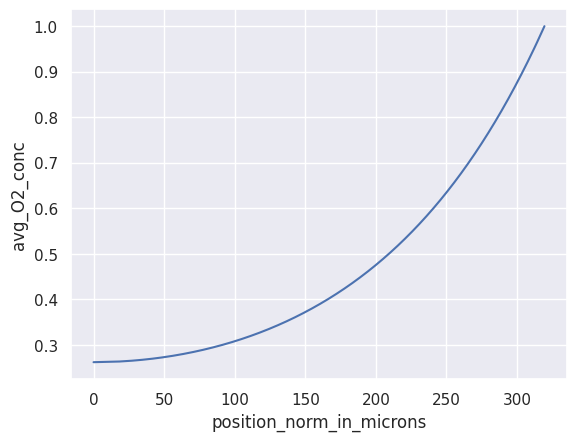

In [7]:
sns.lineplot(data=df, x="position_norm_in_microns", y="avg_O2_conc")
plt.show()

### Survival Probability

In [8]:
# s = 1 - f(r)
df["survival_probability"] = 1 - df["avg_O2_conc"]

# we kill when survival_probability < susceptibility (a random number)
df["killed"] = df["survival_probability"] < df["susceptibility"]

df.head()

,position_norm_in_radii,stemness,active,susceptibility,position_norm_in_microns,avg_O2_conc,survival_probability,killed
0,0.000000,True,False,0.894803,0.000000,0.262333,0.737667,True
1,2.000000,True,False,0.633878,16.000000,0.263453,0.736547,False
2,2.000000,False,False,0.612602,16.000000,0.263453,0.736547,False
3,2.974926,False,False,0.078773,23.799412,0.264816,0.735184,False
4,4.683681,False,False,0.829732,37.469450,0.268514,0.731486,True


### Exploration

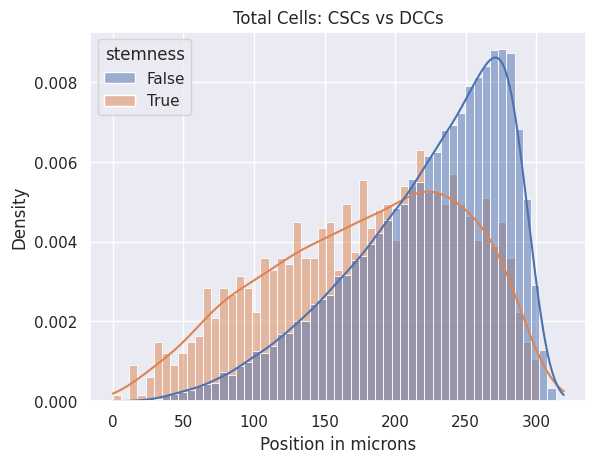

In [9]:
sns.histplot(
    data=df,
    x="position_norm_in_microns",
    hue="stemness",
    kde=True,
    common_norm=False,
    stat="density",
)
plt.title("Total Cells: CSCs vs DCCs")
plt.xlabel("Position in microns")
plt.show()

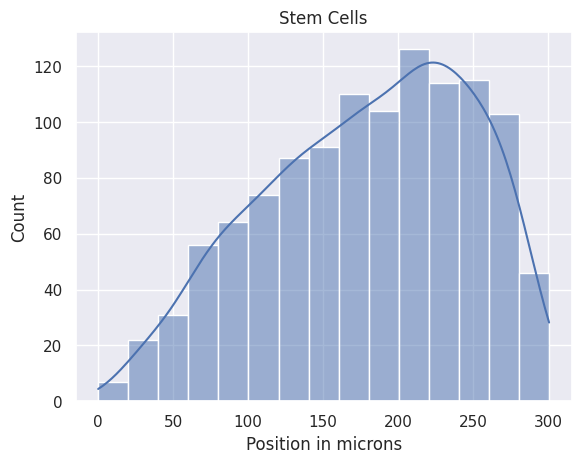

In [10]:
df_stem = df[df["stemness"]]
sns.histplot(data=df_stem, x="position_norm_in_microns", kde=True)
plt.title("Stem Cells")
plt.xlabel("Position in microns")
plt.show()

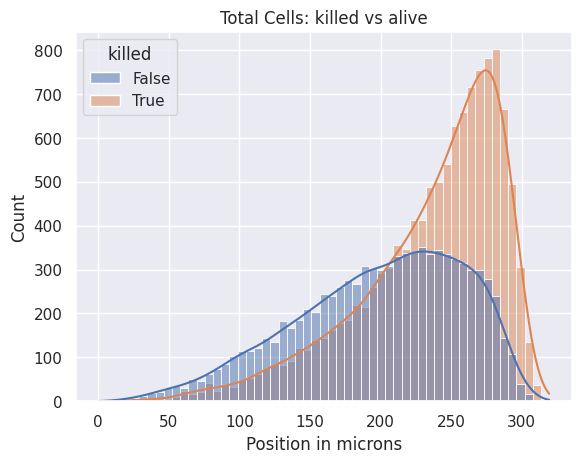

In [11]:
sns.histplot(data=df, x="position_norm_in_microns", hue="killed", kde=True)
plt.title("Total Cells: killed vs alive")
plt.xlabel("Position in microns")
plt.show()

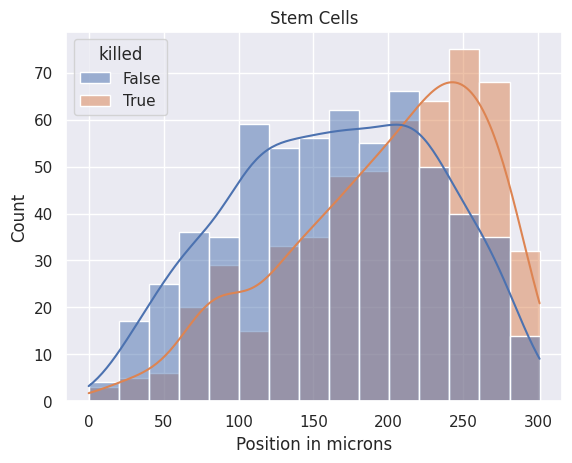

In [12]:
df_stem = df[df["stemness"]]
sns.histplot(
    data=df_stem, x="position_norm_in_microns", hue="killed", kde=True
)
plt.title("Stem Cells")
plt.xlabel("Position in microns")
plt.show()

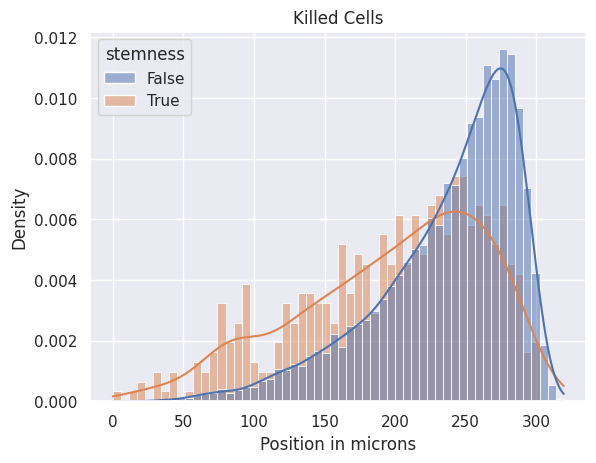

In [13]:
df_killed = df[df["killed"]]
sns.histplot(
    data=df_killed,
    x="position_norm_in_microns",
    hue="stemness",
    kde=True,
    common_norm=False,
    stat="density",
)
plt.title("Killed Cells")
plt.xlabel("Position in microns")
plt.show()

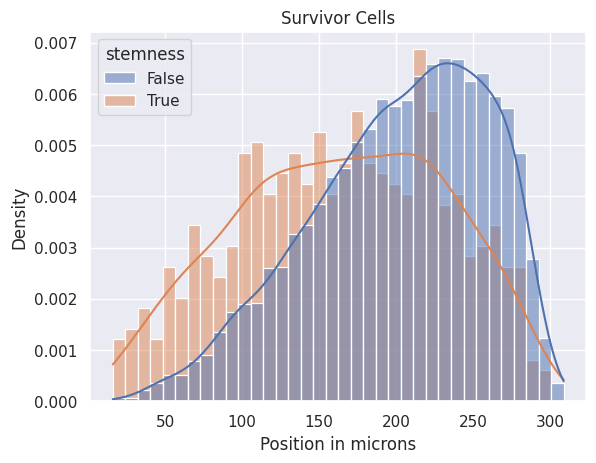

In [14]:
df_alive = df[df["killed"] == False]
sns.histplot(
    data=df_alive,
    x="position_norm_in_microns",
    hue="stemness",
    kde=True,
    common_norm=False,
    stat="density",
)
plt.title("Survivor Cells")
plt.xlabel("Position in microns")
plt.show()

### Percentage Alive vs location

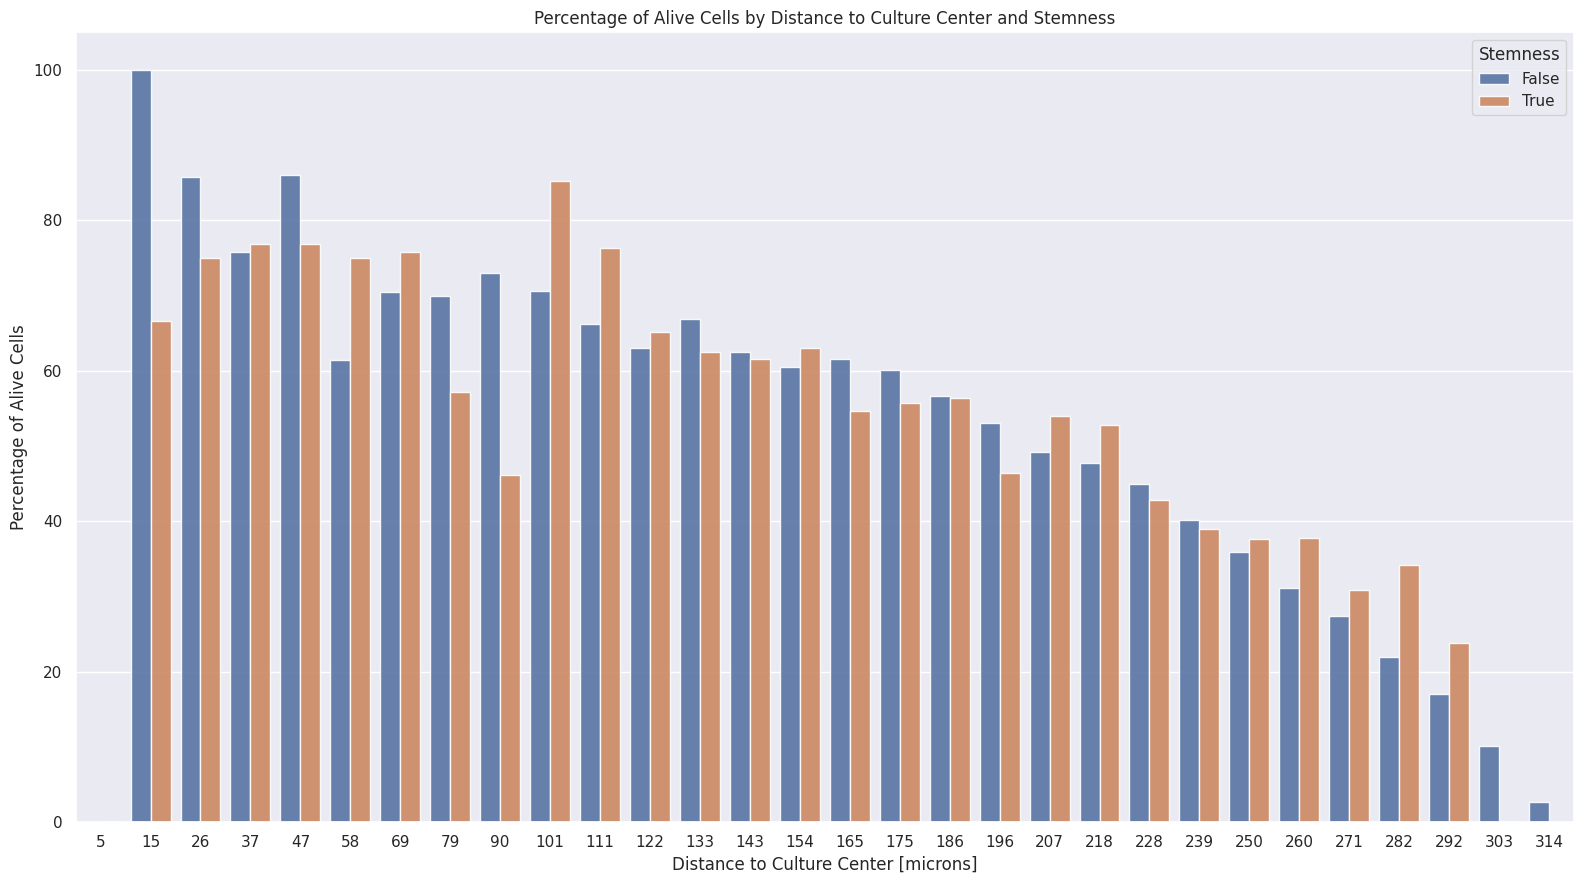

In [15]:
# Step 1: Create Bins
bins = 30  # Number of bins
df["bin"] = pd.cut(df["position_norm_in_microns"], bins=bins)

# Step 2: Calculate Alive and Total Counts per Bin and Stemness
# Total counts per bin and stemness
total_counts = (
    df.groupby(["bin", "stemness"], observed=True)
    .size()
    .reset_index(name="total")
)

# Alive counts per bin and stemness
alive_counts = (
    df[df["killed"] == False]
    .groupby(["bin", "stemness"], observed=True)
    .size()
    .reset_index(name="alive")
)

# Merge total and alive counts
counts = pd.merge(
    total_counts, alive_counts, on=["bin", "stemness"], how="left"
)
counts["alive"] = counts["alive"].fillna(
    0
)  # Replace NaN with 0 for bins with no alive cells

# Calculate Alive Percentage
counts["alive_percentage"] = (counts["alive"] / counts["total"]) * 100

# Step 3: Prepare X-axis Labels
# Convert bin intervals to midpoint string for categorical x-axis
counts["bin_mid"] = counts["bin"].apply(lambda x: int((x.left + x.right) / 2))

# Set the style
sns.set(style="darkgrid")  # Set plot style

plt.figure(figsize=(16, 9))  # Set figure size

# Create bar plot
ax = sns.barplot(
    data=counts,
    x="bin_mid",  # Use midpoint bin labels
    y="alive_percentage",
    hue="stemness",
    dodge=True,
    alpha=0.9,
)

# Correct the alignment of x-tick labels
plt.xticks(rotation=0, ha="center")

# Set axis labels and title
plt.xlabel("Distance to Culture Center [microns]")
plt.ylabel("Percentage of Alive Cells")
plt.title(
    "Percentage of Alive Cells by Distance to Culture Center and Stemness"
)

# Adjust layout to ensure everything fits without overlapping
plt.tight_layout()

# Display legend appropriately
plt.legend(title="Stemness", loc="upper right")

# Show plot
plt.show()

## Random Relocation
We want to add a new column called `'new_stemness'`, where at the beginning all values are set to False. Then, we randomly choose rows to change their `'new_stemness'` value to `True`. I want to do this in such a way that all rows have the same probability to be chosen, and such that, at the end of the process, there is the same number of values True in `'new_stemness'` than in the original `'stemness'` column. In other words, if there are $S$ rows which have `'stemness' = True`, I want to make a column `'new_stemness'` that also has a total of $S$ rows chosen at random with a value of `True`.

### Example case

In [17]:
print(f"Stem cell fraction: {df.loc[df['stemness']==True].size/df.size}")

Stem cell fraction: 0.054173732805728285


In [19]:
# Step 1: Initialize the 'new_stemness' column with all values set to False
df["new_stemness"] = False

# Step 2: Determine the number of True values in the original 'stemness' column
num_true_stemness = df["stemness"].sum()

# Step 3: Randomly select indices to set 'new_stemness' to True
random_indices = np.random.choice(
    df.index, size=num_true_stemness, replace=False
)

# Step 4: Set the 'new_stemness' values at the selected indices to True
df.loc[random_indices, "new_stemness"] = True

# Let's check the result
print(f"Original number of stem cells: {num_true_stemness}")
print(f"New number of stem cells: {df['new_stemness'].sum()}")

df.head()

Original number of stem cells: 1150
New number of stem cells: 1150


,position_norm_in_radii,stemness,active,susceptibility,position_norm_in_microns,avg_O2_conc,survival_probability,killed,bin,new_stemness
0,0.000000,True,False,0.894803,0.000000,0.262333,0.737667,True,"(-0.319, 10.648]",False
1,2.000000,True,False,0.633878,16.000000,0.263453,0.736547,False,"(10.648, 21.296]",False
2,2.000000,False,False,0.612602,16.000000,0.263453,0.736547,False,"(10.648, 21.296]",False
3,2.974926,False,False,0.078773,23.799412,0.264816,0.735184,False,"(21.296, 31.944]",False
4,4.683681,False,False,0.829732,37.469450,0.268514,0.731486,True,"(31.944, 42.591]",False


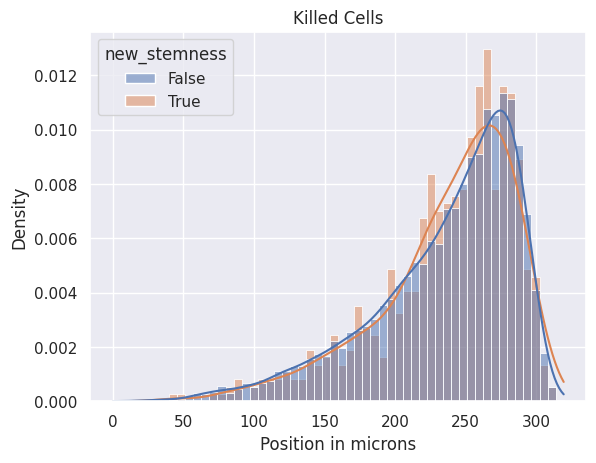

In [20]:
df_killed = df[df["killed"]]
sns.histplot(
    data=df_killed,
    x="position_norm_in_microns",
    hue="new_stemness",
    kde=True,
    common_norm=False,
    stat="density",
)
plt.title("Killed Cells")
plt.xlabel("Position in microns")
plt.show()

Efectivamente las distribuciones se igualan, como esperábamos. Para comparar posta esto con lo anterior y hacer un ensamble, hace falta definir algún valor a comparar.

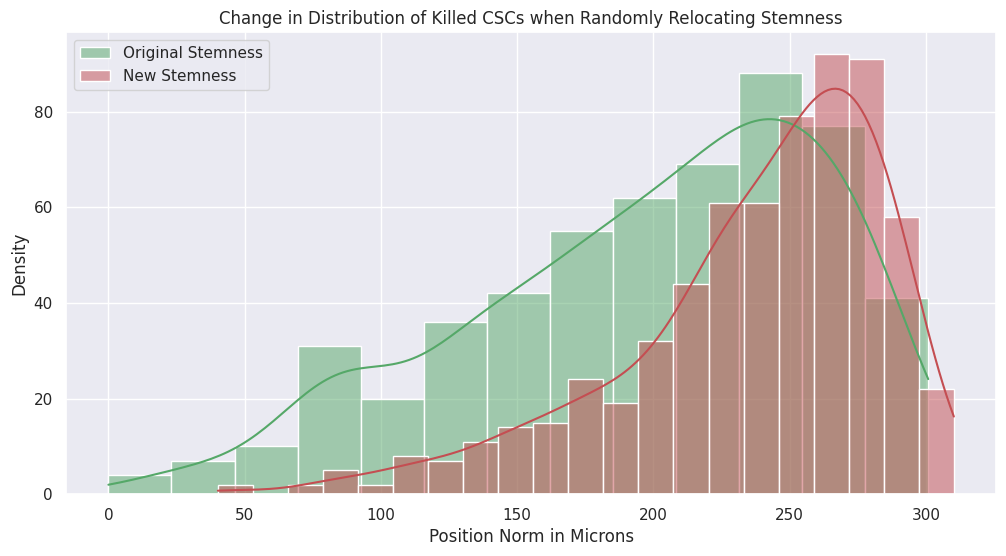

In [28]:
# Define the dataframes for the original and new stemness of killed cells
df_original_killed_stem = df[(df["killed"]) & (df["stemness"])]
df_new_killed_stem = df[(df["killed"]) & (df["new_stemness"])]

# Extract the default color palette
default_palette = sns.color_palette()

# Plot the histograms
plt.figure(figsize=(12, 6))

# stat = "density"
stat = "count"

sns.histplot(
    data=df_original_killed_stem,
    x="position_norm_in_microns",
    color=default_palette[2],
    label="Original Stemness",
    kde=True,
    stat=stat,
)
sns.histplot(
    data=df_new_killed_stem,
    x="position_norm_in_microns",
    color=default_palette[3],
    label="New Stemness",
    kde=True,
    stat=stat,
)

plt.xlabel("Position Norm in Microns")
plt.ylabel("Density")
plt.title(
    "Change in Distribution of Killed CSCs when Randomly Relocating Stemness"
)
plt.legend()
plt.show()

#### Comparing momenta of the dist

In [29]:
import scipy.stats as stats

# Filter the data
original_stemness = df[df["stemness"] == True]["position_norm_in_microns"]
new_stemness = df[df["new_stemness"] == True]["position_norm_in_microns"]

# Calculate moments for the original stemness distribution
mean_original = original_stemness.mean()
std_original = original_stemness.std()
skew_original = stats.skew(original_stemness)
kurtosis_original = stats.kurtosis(original_stemness)

# Calculate moments for the new stemness distribution
mean_new = new_stemness.mean()
std_new = new_stemness.std()
skew_new = stats.skew(new_stemness)
kurtosis_new = stats.kurtosis(new_stemness)

# Print the results
print("Original Stemness Distribution:")
print(f"Mean: {mean_original}")
print(f"Standard Deviation: {std_original}")
print(f"Skewness: {skew_original}")
print(f"Kurtosis: {kurtosis_original}\n")

print("New Stemness Distribution:")
print(f"Mean: {mean_new}")
print(f"Standard Deviation: {std_new}")
print(f"Skewness: {skew_new}")
print(f"Kurtosis: {kurtosis_new}\n")

Original Stemness Distribution:
Mean: 179.86630136519676
Standard Deviation: 68.67615956304594
Skewness: -0.3439777969755439
Kurtosis: -0.7945078445549392

New Stemness Distribution:
Mean: 222.49910371038897
Standard Deviation: 55.59311907729843
Skewness: -0.9361042561840569
Kurtosis: 0.4277919744488954



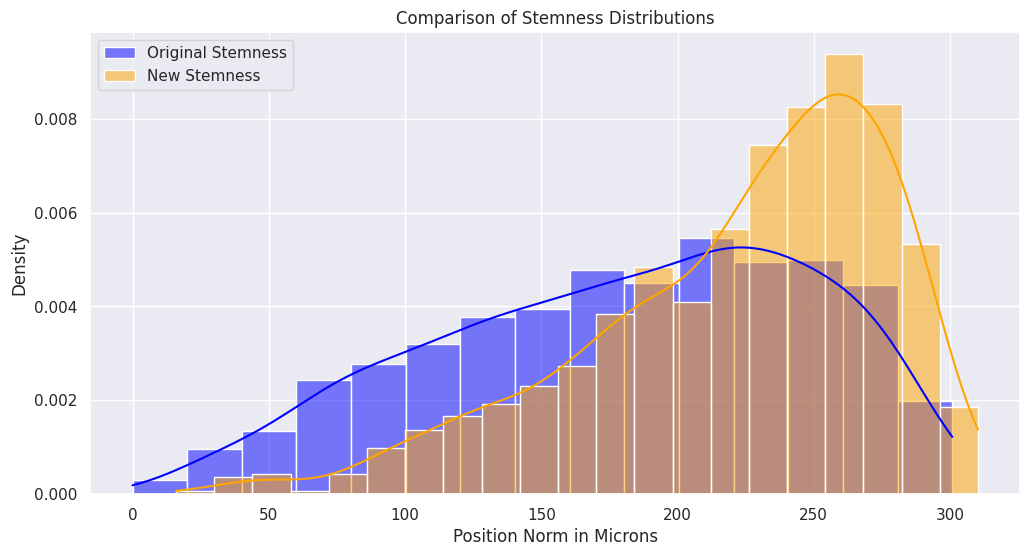

In [30]:
# Plot histograms for visual comparison
plt.figure(figsize=(12, 6))

sns.histplot(
    original_stemness,
    color="blue",
    label="Original Stemness",
    kde=True,
    stat="density",
)
sns.histplot(
    new_stemness,
    color="orange",
    label="New Stemness",
    kde=True,
    stat="density",
)

plt.xlabel("Position Norm in Microns")
plt.ylabel("Density")
plt.title("Comparison of Stemness Distributions")
plt.legend()
plt.show()

## Kolmogorov-Smirnov test
The Kolmogorov–Smirnov test (K–S test or KS test) is a nonparametric statistics of the equality of continuous (or discontinuous), one-dimensional probability distributions that can be used to test:
- whether a random sample came from a given reference probability distribution (one-sample K–S test) – that is, the test provides a method to qualitatively answer the question "How likely is it that we would see a collection of samples like this if they were drawn from that probability distribution?";
- or to test whether two samples came from the same distribution (two-sample K–S test) – that is "How likely is it that we would see two sets of samples like this if they were drawn from the same (but unknown) probability distribution?".

In this case, we want to use the two-sample K–S test to compare the distribution of killed CSCs, according to `'new_stemness'` and `'stemness'`, over `'position_norm_in_microns'`.

---


The Kolmogorov–Smirnov test may also be used to test whether two underlying one-dimensional probability distributions differ. In this case, the Kolmogorov–Smirnov statistic is

$$D_{n,m}=\sup_x |F_{1,n}(x)-F_{2,m}(x)|,$$

where $F_{1,n}$ and $F_{2,m}$ are the empirical distribution functions of the first and the second sample respectively, and $\sup is the supremum function.

For large samples, the null hypothesis is rejected at level $\alpha$ if

$$D_{n,m}>c(\alpha)\sqrt{\frac{n + m}{n\cdot m}}.$$

Where $n$ and $m$ are the sizes of first and second sample respectively. The value of $c(\alpha)$ is given (ref: Eq. (15) in Section 3.3.1 of Knuth, D.E., The Art of Computer Programming, Volume 2 (Seminumerical Algorithms), 3rd Edition, Addison Wesley, Reading Mass, 1998.) by

$$c\left(\alpha\right)=\sqrt{-\ln\left(\tfrac{\alpha}{2}\right)\cdot \tfrac{1}{2}},$$

so that the condition reads

$$D_{n,m}>\sqrt{-\ln\left(\tfrac{\alpha}{2}\right)\cdot \tfrac{1 + \tfrac{m}{n}}{2m}}.$$

Here, again, the larger the sample sizes, the more sensitive the minimal bound: For a given ratio of sample sizes (e.g. $m=n$), the minimal bound scales in the size of either of the samples according to its inverse square root. 

Note that the two-sample test checks whether the two data samples come from the same distribution. This does not specify what that common distribution is (e.g. whether it's normal or not normal). Again, tables of critical values have been published. A shortcoming of the univariate Kolmogorov–Smirnov test is that it is not very powerful because **it is devised to be sensitive against all possible types of differences between two distribution functions.** Some argue that the Cucconi test, originally proposed for simultaneously comparing location and scale, can be much more powerful than the Kolmogorov–Smirnov test when comparing two distribution functions.

Note: you can also use the Kolmogorov–Smirnov test to set confidence limits for the shape of a distribution function.


In [31]:
import scipy.stats as stats

# Filter the data
original_stemness = df[df["stemness"] == True]["position_norm_in_microns"]
new_stemness = df[df["new_stemness"] == True]["position_norm_in_microns"]

# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = stats.ks_2samp(original_stemness, new_stemness)

# Print the results
print("Kolmogorov-Smirnov Test:")
print(f"KS Statistic: {ks_statistic}")
print(f"P-Value: {p_value}")

# Interpretation
alpha = 0.01
if p_value < alpha:
    print(
        "Result: The distributions are significantly different (reject the null hypothesis)."
    )
else:
    print(
        "Result: The distributions are not significantly different (fail to reject the null hypothesis)."
    )

Kolmogorov-Smirnov Test:
KS Statistic: 0.2808695652173913
P-Value: 2.4221365958616967e-40
Result: The distributions are significantly different (reject the null hypothesis).


### Ensemble for statistical test
No sé si vale la pena hacer esto, ya que para hacer el test con un ensamble, tendría que elegir algún valor con el que caracterizar las distribuciones para comparar. Teniendo las distribuciones, creo que me conviene comparar con un test de KS.